# Basic CNN Model - Log-Mel Spectrograms

To compare the results from the previous notebook between MFCC and Log-Mel Spectrograms features I'm going to replicate the same basic CNN model training procedure of that notebook

In [30]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
import helpers

from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [31]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

In [32]:
# Pre-processed MFCC coefficients
X = np.load("C:/Users/ishaa/OneDrive/Desktop/extracted features/X-Chrom.npy")
y = np.load("C:/Users/ishaa/OneDrive/Desktop/extracted features/Y-Chrom.npy")

# Metadata
path = 'C:/Users/ishaa/OneDrive/Desktop/dataset/'
file = 'UrbanSound8K.csv'

# Use pandas read_csv directly
meta_data = pd.read_csv(path + file)
meta_data.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [33]:
indexes = []
total = len(meta_data)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = meta_data.iloc[test_split_idx]
train_meta = meta_data.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))


Test split: 1746 		 Train split: 6986
X test shape: (1746, 40, 174) 	 X train shape: (6986, 40, 174)
y test shape: (1746,) 		 y train shape: (6986,)


One hot encode labels

In [34]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

Reshape Data

In [35]:
# How data should be structured
num_rows = 40
num_columns = 174 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

In [36]:
# Class distribution
meta_data['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

Check PCA benefits

Text(0, 0.5, 'Variance (%)')

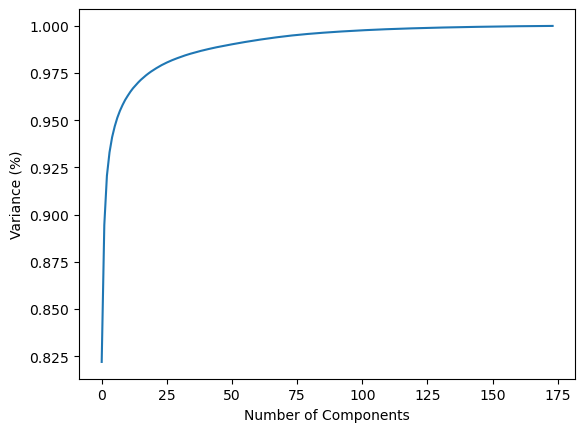

In [37]:
scaler = StandardScaler()
scaler.fit(X_train[:,0, ::,0])
x_train_scaled = scaler.transform(X_train[:,0, ::,0])

pca = PCA().fit(x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')

# Basic CNN network

Model definition

In [38]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)


# Setup model optimizer and loss function

Using ADAM with default parameters to start from somewhere. Loss function is categorical cross-entropy as we are predicting between 10 classes.

In [39]:
adam = Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 38, 172, 32)       320       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 38, 172, 32)       0         
                                                                 
 batch_normalization_4 (Bat  (None, 38, 172, 32)       128       
 chNormalization)                                                
                                                                 
 spatial_dropout2d_3 (Spati  (None, 38, 172, 32)       0         
 alDropout2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 36, 170, 32)       9248      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 36, 170, 32)      

# Training the model

With Log-Mel Spectrograms it was possible to train for some more epochs before overfitting compared to the previous experiment with MFCC.

In [40]:
num_epochs = 360
num_batch_size = 128
model_file = 'simple-train-nb3.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=1/12.,
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/360
51/51 [==============================] - ETA: 0s - loss: 2.0951 - accuracy: 0.2600
Epoch 1: val_loss improved from inf to 2.66969, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
51/51 [==============================] - 122s 2s/step - loss: 2.0951 - accuracy: 0.2600 - val_loss: 2.6697 - val_accuracy: 0.1304
Epoch 2/360
51/51 [==============================] - ETA: 0s - loss: 1.8581 - accuracy: 0.3380
Epoch 2: val_loss improved from 2.66969 to 2.18613, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
51/51 [==============================] - 115s 2s/step - loss: 1.8581 - accuracy: 0.3380 - val_loss: 2.1861 - val_accuracy: 0.2230
Epoch 3/360
51/51 [==============================] - ETA: 0s - loss: 1.7995 - accuracy: 0.3556
Epoch 3: val_loss improved from 2.18613 to 1.90166, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
51/51 [==============================] - 115s 2s/step - loss: 1.7995 - accuracy: 0.3556 - val

51/51 [==============================] - ETA: 0s - loss: 1.2380 - accuracy: 0.6085
Epoch 25: val_loss did not improve from 1.28066
51/51 [==============================] - 92s 2s/step - loss: 1.2380 - accuracy: 0.6085 - val_loss: 1.3065 - val_accuracy: 0.5575
Epoch 26/360
51/51 [==============================] - ETA: 0s - loss: 1.2078 - accuracy: 0.6180
Epoch 26: val_loss improved from 1.28066 to 1.22459, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
51/51 [==============================] - 91s 2s/step - loss: 1.2078 - accuracy: 0.6180 - val_loss: 1.2246 - val_accuracy: 0.6158
Epoch 27/360
51/51 [==============================] - ETA: 0s - loss: 1.2035 - accuracy: 0.6197
Epoch 27: val_loss improved from 1.22459 to 1.21594, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
51/51 [==============================] - 91s 2s/step - loss: 1.2035 - accuracy: 0.6197 - val_loss: 1.2159 - val_accuracy: 0.6089
Epoch 28/360
51/51 [========================

Epoch 51/360
51/51 [==============================] - ETA: 0s - loss: 1.0157 - accuracy: 0.6805
Epoch 51: val_loss did not improve from 0.98914
51/51 [==============================] - 114s 2s/step - loss: 1.0157 - accuracy: 0.6805 - val_loss: 1.0312 - val_accuracy: 0.6758
Epoch 52/360
51/51 [==============================] - ETA: 0s - loss: 0.9994 - accuracy: 0.6845
Epoch 52: val_loss did not improve from 0.98914
51/51 [==============================] - 114s 2s/step - loss: 0.9994 - accuracy: 0.6845 - val_loss: 1.0032 - val_accuracy: 0.6758
Epoch 53/360
51/51 [==============================] - ETA: 0s - loss: 1.0110 - accuracy: 0.6883
Epoch 53: val_loss did not improve from 0.98914
51/51 [==============================] - 115s 2s/step - loss: 1.0110 - accuracy: 0.6883 - val_loss: 1.0925 - val_accuracy: 0.6346
Epoch 54/360
51/51 [==============================] - ETA: 0s - loss: 0.9918 - accuracy: 0.6917
Epoch 54: val_loss did not improve from 0.98914
51/51 [===========================

51/51 [==============================] - ETA: 0s - loss: 0.8759 - accuracy: 0.7432
Epoch 78: val_loss did not improve from 0.85612
51/51 [==============================] - 114s 2s/step - loss: 0.8759 - accuracy: 0.7432 - val_loss: 0.8768 - val_accuracy: 0.7273
Epoch 79/360
51/51 [==============================] - ETA: 0s - loss: 0.8802 - accuracy: 0.7357
Epoch 79: val_loss did not improve from 0.85612
51/51 [==============================] - 114s 2s/step - loss: 0.8802 - accuracy: 0.7357 - val_loss: 0.8601 - val_accuracy: 0.7307
Epoch 80/360
51/51 [==============================] - ETA: 0s - loss: 0.8663 - accuracy: 0.7481
Epoch 80: val_loss improved from 0.85612 to 0.84060, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
51/51 [==============================] - 115s 2s/step - loss: 0.8663 - accuracy: 0.7481 - val_loss: 0.8406 - val_accuracy: 0.7616
Epoch 81/360
51/51 [==============================] - ETA: 0s - loss: 0.8771 - accuracy: 0.7422
Epoch 81: val_loss i

Epoch 105/360
51/51 [==============================] - ETA: 0s - loss: 0.7831 - accuracy: 0.7812
Epoch 105: val_loss improved from 0.74633 to 0.73607, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
51/51 [==============================] - 89s 2s/step - loss: 0.7831 - accuracy: 0.7812 - val_loss: 0.7361 - val_accuracy: 0.8079
Epoch 106/360
51/51 [==============================] - ETA: 0s - loss: 0.7887 - accuracy: 0.7767
Epoch 106: val_loss did not improve from 0.73607
51/51 [==============================] - 86s 2s/step - loss: 0.7887 - accuracy: 0.7767 - val_loss: 0.7420 - val_accuracy: 0.7873
Epoch 107/360
51/51 [==============================] - ETA: 0s - loss: 0.7812 - accuracy: 0.7665
Epoch 107: val_loss did not improve from 0.73607
51/51 [==============================] - 85s 2s/step - loss: 0.7812 - accuracy: 0.7665 - val_loss: 0.7490 - val_accuracy: 0.7873
Epoch 108/360
51/51 [==============================] - ETA: 0s - loss: 0.7811 - accuracy: 0.7718
Epo

Epoch 133/360
51/51 [==============================] - ETA: 0s - loss: 0.7126 - accuracy: 0.7957
Epoch 133: val_loss did not improve from 0.66870
51/51 [==============================] - 81s 2s/step - loss: 0.7126 - accuracy: 0.7957 - val_loss: 0.7188 - val_accuracy: 0.7839
Epoch 134/360
51/51 [==============================] - ETA: 0s - loss: 0.7155 - accuracy: 0.7967
Epoch 134: val_loss improved from 0.66870 to 0.66742, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
51/51 [==============================] - 75s 1s/step - loss: 0.7155 - accuracy: 0.7967 - val_loss: 0.6674 - val_accuracy: 0.8216
Epoch 135/360
51/51 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.7998
Epoch 135: val_loss did not improve from 0.66742
51/51 [==============================] - 75s 1s/step - loss: 0.7032 - accuracy: 0.7998 - val_loss: 0.6950 - val_accuracy: 0.8079
Epoch 136/360
51/51 [==============================] - ETA: 0s - loss: 0.7058 - accuracy: 0.8006
Epo

51/51 [==============================] - ETA: 0s - loss: 0.6661 - accuracy: 0.8146
Epoch 160: val_loss improved from 0.61007 to 0.60827, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
51/51 [==============================] - 81s 2s/step - loss: 0.6661 - accuracy: 0.8146 - val_loss: 0.6083 - val_accuracy: 0.8439
Epoch 161/360
51/51 [==============================] - ETA: 0s - loss: 0.6578 - accuracy: 0.8132
Epoch 161: val_loss did not improve from 0.60827
51/51 [==============================] - 81s 2s/step - loss: 0.6578 - accuracy: 0.8132 - val_loss: 0.6116 - val_accuracy: 0.8405
Epoch 162/360
51/51 [==============================] - ETA: 0s - loss: 0.6515 - accuracy: 0.8226
Epoch 162: val_loss did not improve from 0.60827
51/51 [==============================] - 80s 2s/step - loss: 0.6515 - accuracy: 0.8226 - val_loss: 0.6214 - val_accuracy: 0.8353
Epoch 163/360
51/51 [==============================] - ETA: 0s - loss: 0.6523 - accuracy: 0.8231
Epoch 163: val_lo

Epoch 188/360
51/51 [==============================] - ETA: 0s - loss: 0.6090 - accuracy: 0.8334
Epoch 188: val_loss did not improve from 0.55722
51/51 [==============================] - 80s 2s/step - loss: 0.6090 - accuracy: 0.8334 - val_loss: 0.5675 - val_accuracy: 0.8576
Epoch 189/360
51/51 [==============================] - ETA: 0s - loss: 0.5981 - accuracy: 0.8345
Epoch 189: val_loss improved from 0.55722 to 0.54664, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
51/51 [==============================] - 97s 2s/step - loss: 0.5981 - accuracy: 0.8345 - val_loss: 0.5466 - val_accuracy: 0.8662
Epoch 190/360
51/51 [==============================] - ETA: 0s - loss: 0.6000 - accuracy: 0.8351
Epoch 190: val_loss did not improve from 0.54664
51/51 [==============================] - 110s 2s/step - loss: 0.6000 - accuracy: 0.8351 - val_loss: 0.5578 - val_accuracy: 0.8525
Epoch 191/360
51/51 [==============================] - ETA: 0s - loss: 0.5987 - accuracy: 0.8359
Ep

51/51 [==============================] - ETA: 0s - loss: 0.5665 - accuracy: 0.8448
Epoch 216: val_loss improved from 0.50891 to 0.50641, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
51/51 [==============================] - 111s 2s/step - loss: 0.5665 - accuracy: 0.8448 - val_loss: 0.5064 - val_accuracy: 0.8782
Epoch 217/360
51/51 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.8480
Epoch 217: val_loss did not improve from 0.50641
51/51 [==============================] - 110s 2s/step - loss: 0.5559 - accuracy: 0.8480 - val_loss: 0.5144 - val_accuracy: 0.8714
Epoch 218/360
51/51 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.8454
Epoch 218: val_loss did not improve from 0.50641
51/51 [==============================] - 111s 2s/step - loss: 0.5635 - accuracy: 0.8454 - val_loss: 0.5173 - val_accuracy: 0.8679
Epoch 219/360
51/51 [==============================] - ETA: 0s - loss: 0.5476 - accuracy: 0.8540
Epoch 219: val

Epoch 244/360
51/51 [==============================] - ETA: 0s - loss: 0.5127 - accuracy: 0.8646
Epoch 244: val_loss did not improve from 0.47173
51/51 [==============================] - 110s 2s/step - loss: 0.5127 - accuracy: 0.8646 - val_loss: 0.4987 - val_accuracy: 0.8696
Epoch 245/360
51/51 [==============================] - ETA: 0s - loss: 0.5141 - accuracy: 0.8583
Epoch 245: val_loss did not improve from 0.47173
51/51 [==============================] - 110s 2s/step - loss: 0.5141 - accuracy: 0.8583 - val_loss: 0.4737 - val_accuracy: 0.8799
Epoch 246/360
51/51 [==============================] - ETA: 0s - loss: 0.5221 - accuracy: 0.8565
Epoch 246: val_loss did not improve from 0.47173
51/51 [==============================] - 110s 2s/step - loss: 0.5221 - accuracy: 0.8565 - val_loss: 0.4811 - val_accuracy: 0.8799
Epoch 247/360
51/51 [==============================] - ETA: 0s - loss: 0.5234 - accuracy: 0.8565
Epoch 247: val_loss did not improve from 0.47173
51/51 [===================

51/51 [==============================] - ETA: 0s - loss: 0.4819 - accuracy: 0.8760
Epoch 272: val_loss did not improve from 0.44556
51/51 [==============================] - 112s 2s/step - loss: 0.4819 - accuracy: 0.8760 - val_loss: 0.4683 - val_accuracy: 0.8868
Epoch 273/360
51/51 [==============================] - ETA: 0s - loss: 0.4819 - accuracy: 0.8749
Epoch 273: val_loss improved from 0.44556 to 0.44252, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
51/51 [==============================] - 112s 2s/step - loss: 0.4819 - accuracy: 0.8749 - val_loss: 0.4425 - val_accuracy: 0.9022
Epoch 274/360
51/51 [==============================] - ETA: 0s - loss: 0.4813 - accuracy: 0.8737
Epoch 274: val_loss did not improve from 0.44252
51/51 [==============================] - 112s 2s/step - loss: 0.4813 - accuracy: 0.8737 - val_loss: 0.4450 - val_accuracy: 0.8902
Epoch 275/360
51/51 [==============================] - ETA: 0s - loss: 0.4867 - accuracy: 0.8640
Epoch 275: val

51/51 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.8824
Epoch 301: val_loss did not improve from 0.42576
51/51 [==============================] - 74s 1s/step - loss: 0.4640 - accuracy: 0.8824 - val_loss: 0.4353 - val_accuracy: 0.8937
Epoch 302/360
51/51 [==============================] - ETA: 0s - loss: 0.4749 - accuracy: 0.8727
Epoch 302: val_loss did not improve from 0.42576
51/51 [==============================] - 78s 2s/step - loss: 0.4749 - accuracy: 0.8727 - val_loss: 0.4687 - val_accuracy: 0.8782
Epoch 303/360
51/51 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.8760
Epoch 303: val_loss improved from 0.42576 to 0.42314, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
51/51 [==============================] - 79s 2s/step - loss: 0.4692 - accuracy: 0.8760 - val_loss: 0.4231 - val_accuracy: 0.8816
Epoch 304/360
51/51 [==============================] - ETA: 0s - loss: 0.4515 - accuracy: 0.8791
Epoch 304: val_lo

Epoch 330/360
51/51 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.8697
Epoch 330: val_loss did not improve from 0.39394
51/51 [==============================] - 84s 2s/step - loss: 0.4656 - accuracy: 0.8697 - val_loss: 0.5175 - val_accuracy: 0.8559
Epoch 331/360
51/51 [==============================] - ETA: 0s - loss: 0.4615 - accuracy: 0.8780
Epoch 331: val_loss did not improve from 0.39394
51/51 [==============================] - 85s 2s/step - loss: 0.4615 - accuracy: 0.8780 - val_loss: 0.4520 - val_accuracy: 0.8919
Epoch 332/360
51/51 [==============================] - ETA: 0s - loss: 0.4523 - accuracy: 0.8841
Epoch 332: val_loss did not improve from 0.39394
51/51 [==============================] - 86s 2s/step - loss: 0.4523 - accuracy: 0.8841 - val_loss: 0.4547 - val_accuracy: 0.8851
Epoch 333/360
51/51 [==============================] - ETA: 0s - loss: 0.4432 - accuracy: 0.8880
Epoch 333: val_loss did not improve from 0.39394
51/51 [======================

51/51 [==============================] - ETA: 0s - loss: 0.4385 - accuracy: 0.8827
Epoch 359: val_loss did not improve from 0.38317
51/51 [==============================] - 85s 2s/step - loss: 0.4385 - accuracy: 0.8827 - val_loss: 0.4187 - val_accuracy: 0.8885
Epoch 360/360
51/51 [==============================] - ETA: 0s - loss: 0.4227 - accuracy: 0.8916
Epoch 360: val_loss did not improve from 0.38317
51/51 [==============================] - 84s 2s/step - loss: 0.4227 - accuracy: 0.8916 - val_loss: 0.4091 - val_accuracy: 0.8902
Training completed in time:  16:15:41.026845


# General model evaluation

Note that we first load the checkpoint with the lowest validation loss achieved during training

In [41]:
# Load best saved model
model = load_model(model_path)

helpers.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.3240       92.5852
Test:             0.3616       91.0653
Normal diff         10.41 


Compared with the previous evaluation the model was able to train for more epochs when using Mel Spectrograms, and consequently, a higher accuracy and lower error where achieved.

# Train vs Test history plot

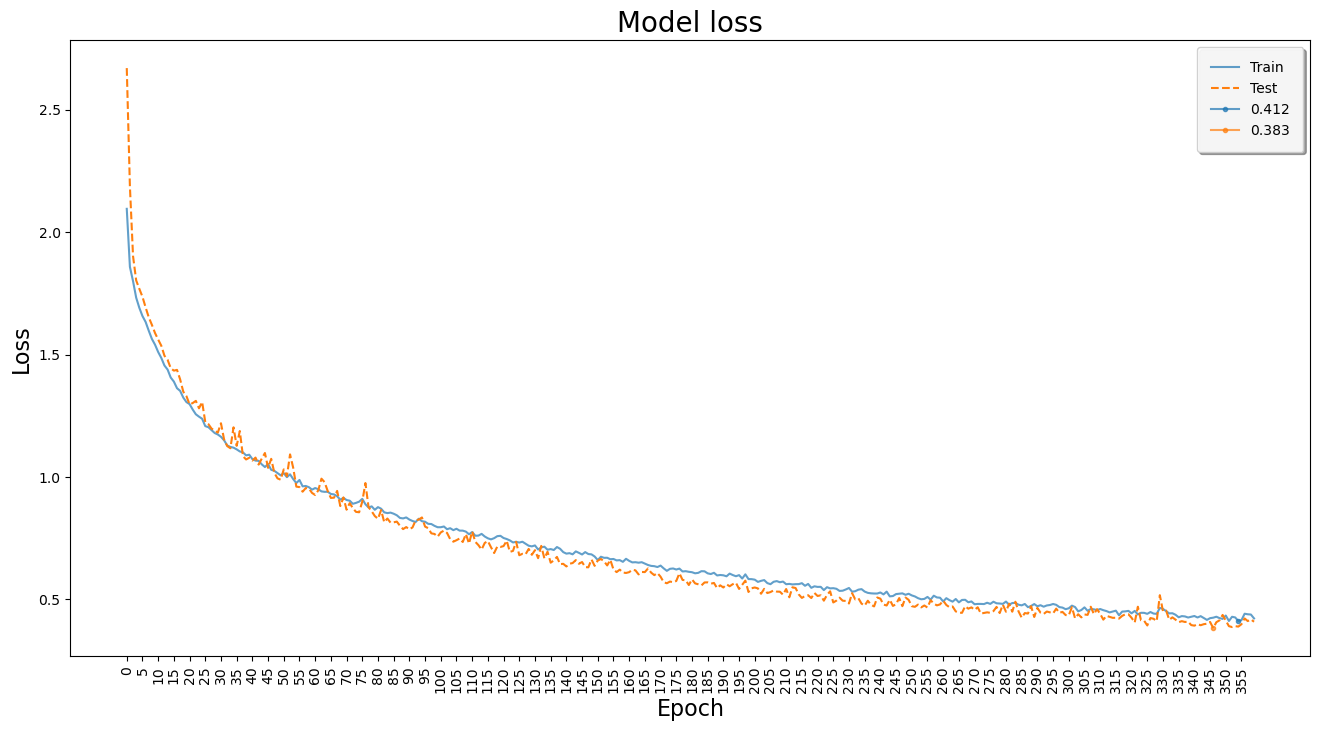

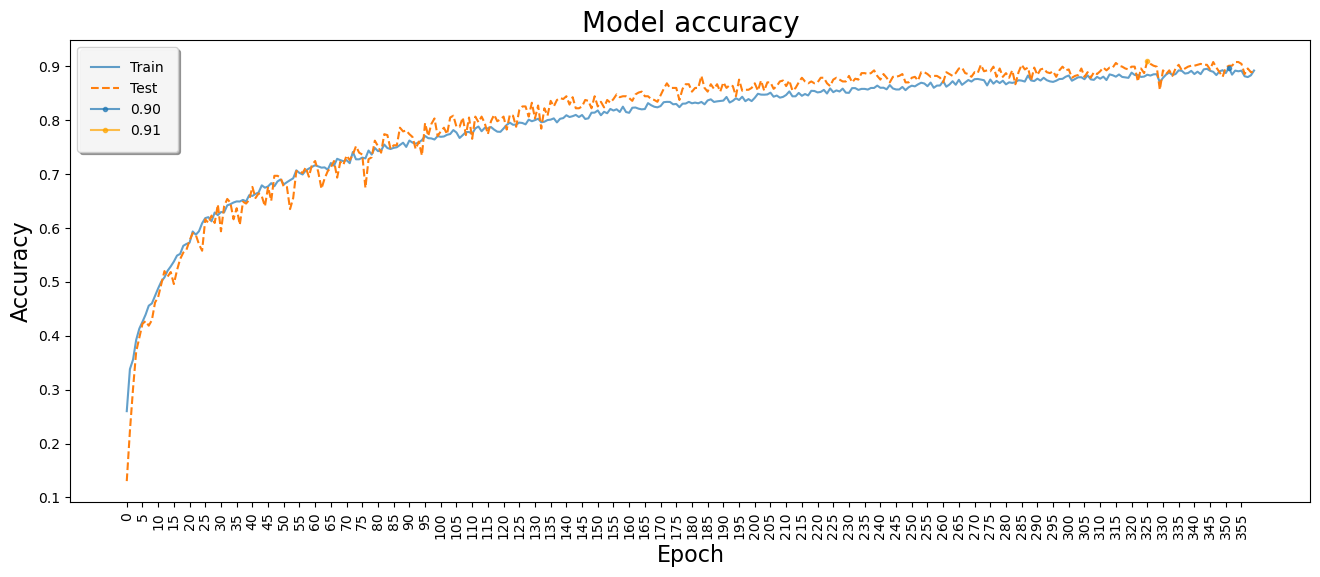

In [42]:
helpers.plot_train_history(history, x_ticks_vertical=True)

Although the shape of the curves are similar to the ones of the previous experiment, the generalization gap is thinner. If we look at the error minimums we also find out that there is a smaller difference between validation and train errors.



# Model evaluation

# Register model output

In [43]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

# Confussion matrix

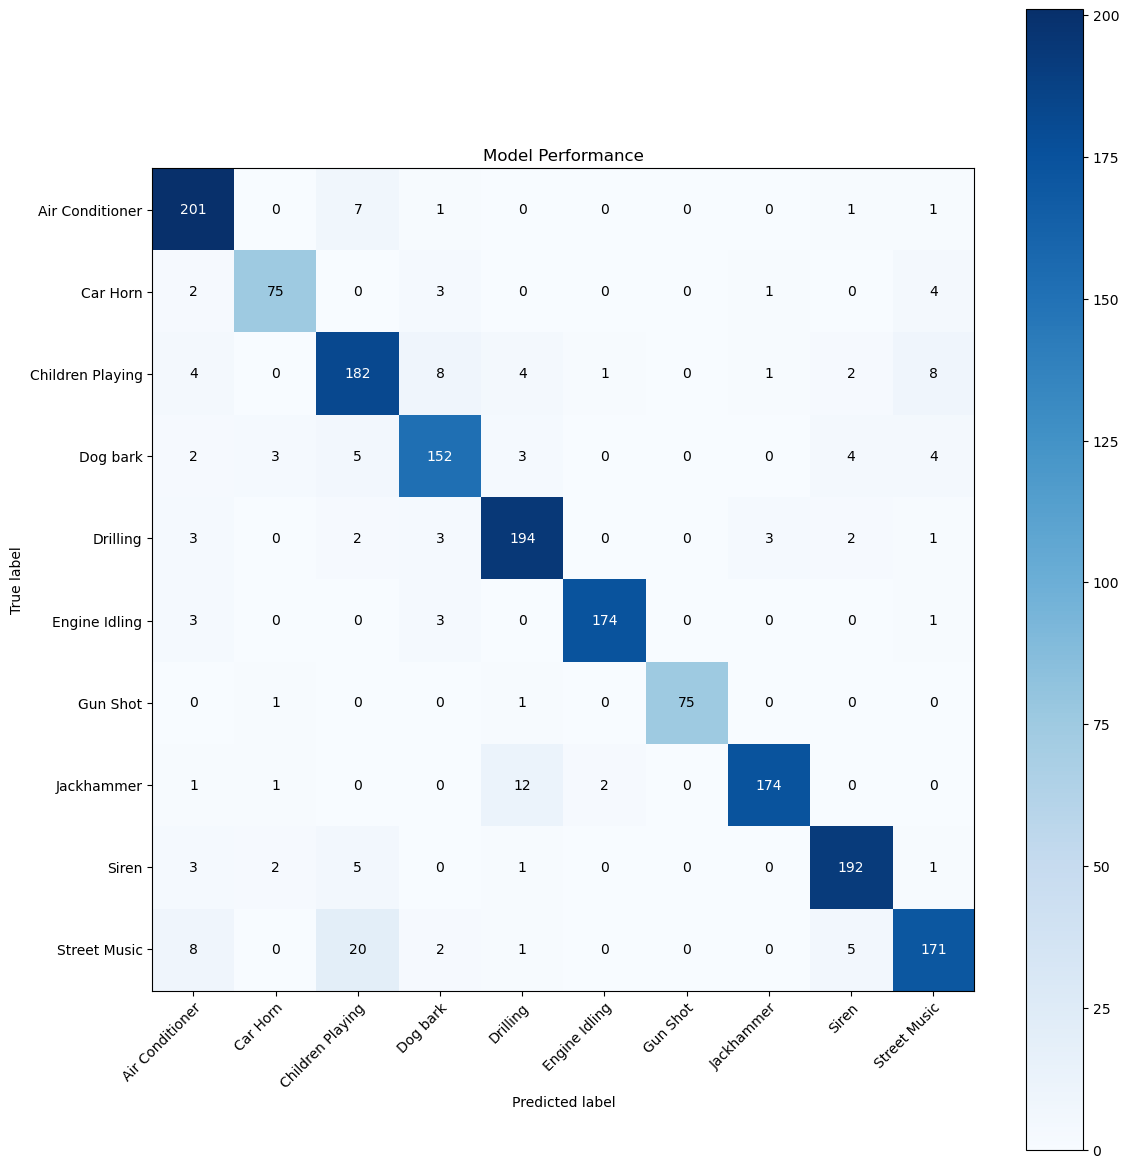

In [44]:
import importlib
importlib.reload(helpers)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helpers.plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(12,12))

The patterns found on working with MFCC are replicated, but most of the true positives have increased and false negatives have decreased.



# Accuracy table

In [45]:
# Find per-class accuracy from the confusion matrix data
accuracies = helpers.acc_per_class(cm)

pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,97.402597
5,Engine Idling,96.132597
0,Air Conditioner,95.260664
8,Siren,94.117647
4,Drilling,93.269231
7,Jackhammer,91.578947
1,Car Horn,88.235294
3,Dog bark,87.861272
2,Children Playing,86.666667
9,Street Music,82.608696


In a similar fashion, most class-accuracies have increased.

# Classification performance: Presicion, Recall and F1 scores

In [46]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.89      0.95      0.92       211
        Car Horn       0.91      0.88      0.90        85
Children Playing       0.82      0.87      0.84       210
        Dog bark       0.88      0.88      0.88       173
        Drilling       0.90      0.93      0.92       208
   Engine Idling       0.98      0.96      0.97       181
        Gun Shot       1.00      0.97      0.99        77
      Jackhammer       0.97      0.92      0.94       190
           Siren       0.93      0.94      0.94       204
    Street Music       0.90      0.83      0.86       207

        accuracy                           0.91      1746
       macro avg       0.92      0.91      0.92      1746
    weighted avg       0.91      0.91      0.91      1746



Scores have increased a bit in average, we still see the same general patterns.

Street music got the lowest Recall score: as we expected for what we saw on the confusion matrix where many class occurrences where classified as Children Playing (false negatives). Similarly, we see that many times some other class was classified as Street Music (false positive), what also lowers the Precision score for this class.

We can identify something similar with Gunshot -an unbalanced class-, where we have the lowest precision score, and if you observe the confusion matrix on the vertical axis, the model identified many other classes as Gunshot (false positives). Quite the opposite occurs on the horizontal axis: we have very little false negatives and a good Recall score for this class.

The other unbalanced class Car Horn has acceptable F1 score, just around the average, but it's a bit low in recall, again, as observed on the horizontal axis of the confusion matrix.

In general, and although we have a we can say the model is quite capable of recognizing relevant data.



# Exploring the misclassified


In [47]:
# Find the target misclassified ocurrencies
street_as_children = test_meta[(test_meta['classID'] == 9) & (test_meta['pred'] == 2)]

files = []
for idx, row in street_as_children.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [48]:
print("Children playing as Street music: {} ocurrencies".format(len(street_as_children)))

# Manully set the file index
index = 12
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

Children playing as Street music: 20 ocurrencies

True category: street_music
File: C:\Users\ishaa\USC_final\UrbanSound8K\audio/fold2/74458-9-1-13.wav


In [49]:
#Drilling as Jack Hammer
# Find the target misclassified ocurrencies
drilling_as_jack = test_meta[(test_meta['classID'] == 4) & (test_meta['pred'] == 7)]
files = []
for idx, row in drilling_as_jack.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [50]:
print("Drilling as Jack Hammer: {} ocurrencies".format(len(drilling_as_jack)))

# Manully set the file index
index = 12
   
# Display results
print("\nTrue category: {}".format(category))

Drilling as Jack Hammer: 3 ocurrencies

True category: drilling
